In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import math

/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
#read the input
#read the input
features_df= pd.read_csv('new_SE_pt5_4000.csv',header=None)
labels= pd.read_csv('label.csv')


In [3]:
#convert into numpy
features= features_df.values

labels= labels.values
features= features[:,0:1000]

print(features.shape)

(28992, 1000)


In [4]:
#new calculation of Performance metric
from sklearn.model_selection import StratifiedKFold
from itertools import cycle
from scipy import interp

cv = StratifiedKFold(n_splits=10)
clf = DecisionTreeClassifier(random_state=0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i= 0

print(features.shape)
print(labels.shape)

accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []

for train, test in cv.split(features, labels):
    probas_ = clf.fit(features[train], labels[train]).predict_proba(features[test])
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

    
    #print(y_test.shape,probas_.shape)
    cm = confusion_matrix(labels[test],probas_[:,1])
    #print("Initial cm:\n",cm)
    if(cm.shape[0]==1):
        new_cm= np.zeros([2,2])
        #print("y_test label:",y_test)
        #zrow= np.zeros((1,2),dtype=int)
        #zcol= np.zeros((1,1),dtype=int)
        new_cm[0,0]= 0
        new_cm[0,1]= 0
        new_cm[1,0]= 0
        new_cm[1,1]= cm[0]
        #cm= np.concatenate((cm,zcol),axis=1)
        #cm= np.concatenate((cm,zrow),axis=0)
        cm= new_cm
    #print("modify cm:\n",cm)
    #print(type(cm))
    #print("shape",cm.shape)
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    #print(acc,prec,sens,spec,f1)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    if(math.isnan(spec)):
        print("Nan")
    else:
        specificity.append(spec)
    f1score.append(f1)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

(28992, 1000)
(28992, 1)


In [5]:
print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))

Accuracy: 90.6042978511
Precision: 91.9466492758
Sensitivity: 89.0106089812
Specificity: 92.1979867209
F1_score: 90.4477092347


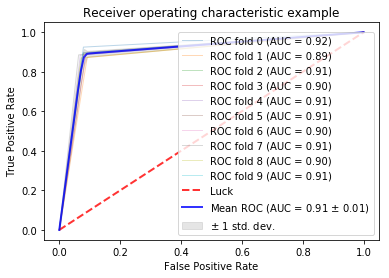

In [6]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()